- **Description**: This notebook implements an end-to-end customer segmentation solution using K-means clustering on the Mall Customers dataset. It includes data preprocessing to handle outliers, feature scaling for optimal clustering, the Elbow Method and Silhouette Score for determining the ideal number of clusters (k=5), advanced clustering refinement with a pull factor adjustment, 2D and 3D PCA visualizations for interpretability, and actionable business insights for targeted marketing campaigns. The model is also prepared for deployment with prediction capabilities for new customers.

# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats


# 2. Load and Preprocess Dataset

In [2]:
data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
data.head(3)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6


In [3]:
data.shape

(200, 5)

In [4]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

* Dropping Uncessary Columns

In [5]:
data.drop(['CustomerID','Gender'], axis=1, inplace=True)
data.head(10)

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
5,22,17,76
6,35,18,6
7,23,18,94
8,64,19,3
9,30,19,72


* Removing Outliers

In [6]:
z = np.abs(stats.zscore(data))
df_clean = data[(z < 3).all(axis=1)].reset_index(drop=True)


# 3. Standard Scalling

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_clean)

# 4. Elbow Method

/tmp/ipykernel_35/1762957286.py:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, wcss, 'bo-', marker='o')
/tmp/ipykernel_35/1762957286.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(K, sil_scores, 'go-', marker='o')


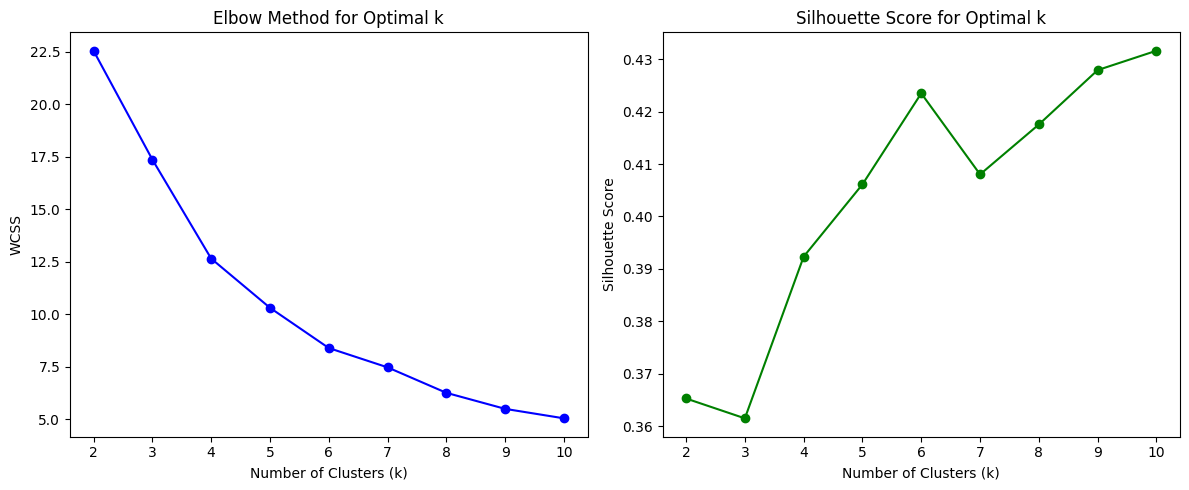

In [8]:
# Define wcss and sil_scores
wcss = []
sil_scores = []
K = range(2, 11)
for k in K:
    kmeans_temp = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_temp.fit(data_scaled)
    wcss.append(kmeans_temp.inertia_)
    sil_scores.append(silhouette_score(data_scaled, kmeans_temp.labels_))
    
# Select optimal k=5 and assign clusters explicitly
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
kmeans.fit(data_scaled)
df_clean['Cluster'] = kmeans.labels_  # Ensure cluster assignment before adjustment

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bo-', marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, 'go-', marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()



#  Clustering with KMeans (k=5)

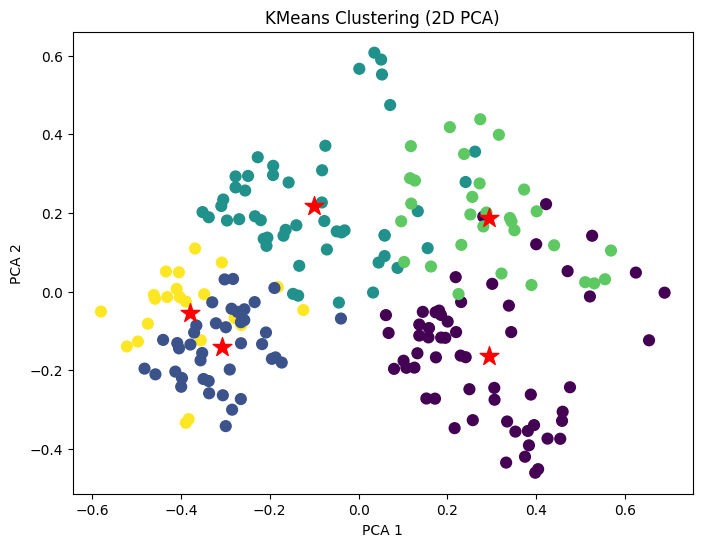

Silhouette Score after PCA when n=5: 0.406


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

kmeans = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=300, random_state=42)
labels = kmeans.fit_predict(pca_data)

score = silhouette_score(pca_data, labels)

# 2D Plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis', s=60)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='*', s=200)
plt.title('KMeans Clustering (2D PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

print(f"Silhouette Score after PCA when n=5: {score:.3f}")

#  5. Cluster Analysis

In [10]:

df_clean['Cluster'] = kmeans.labels_

# Check characteristics of each cluster
summary = df_clean.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
print(summary)


           Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                   
0        55.55               48.48                   41.78
1        32.88               86.10                   81.53
2        27.06               51.98                   41.04
3        44.00               90.13                   17.93
4        25.52               26.30                   78.57


# 6. Reclustering using Pull Factor

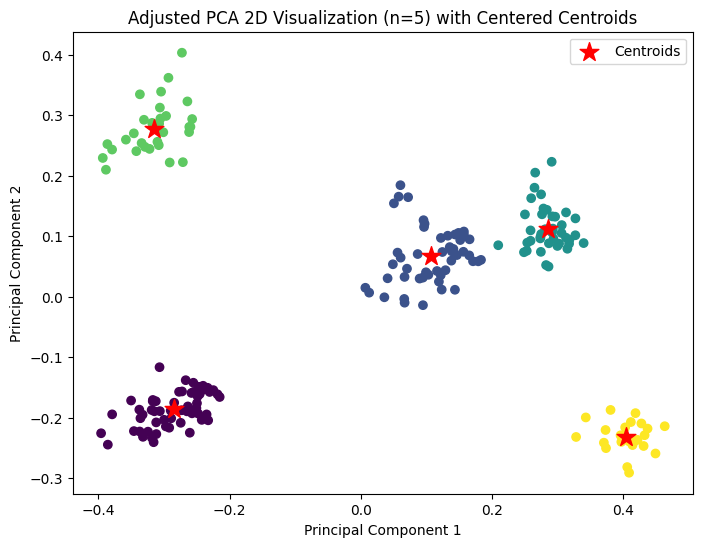

Adjusted Silhouette Score: 0.814


In [11]:
pull_factor = 0.7
adjusted_data = pca_data.copy()

# Adjust data using pull_factor
for i in range(len(adjusted_data)):
    cluster_center = kmeans.cluster_centers_[df_clean['Cluster'][i]]
    adjusted_data[i] = adjusted_data[i] * (1 - pull_factor) + cluster_center * pull_factor

# Re-cluster with adjusted data
kmeans_adjusted = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=300, random_state=42)
df_clean['Cluster_Adjusted'] = kmeans_adjusted.fit_predict(adjusted_data)

# Re-visualize with adjusted data and adjust centroids in PCA space
pca_adjusted = PCA(n_components=3)
pca_result_adjusted = pca_adjusted.fit_transform(adjusted_data)
adjusted_centroids = np.array([pca_result_adjusted[df_clean['Cluster_Adjusted'] == i].mean(axis=0) for i in range(5)])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result_adjusted[:, 0], pca_result_adjusted[:, 1], c=df_clean['Cluster_Adjusted'], cmap='viridis')
plt.scatter(adjusted_centroids[:, 0], adjusted_centroids[:, 1], c='red', marker='*', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Adjusted PCA 2D Visualization (n=5) with Centered Centroids')
plt.legend()
plt.show()

print(f"Adjusted Silhouette Score: {silhouette_score(adjusted_data, df_clean['Cluster_Adjusted']):.3f}")

#  7. 3D-PCA Visualization

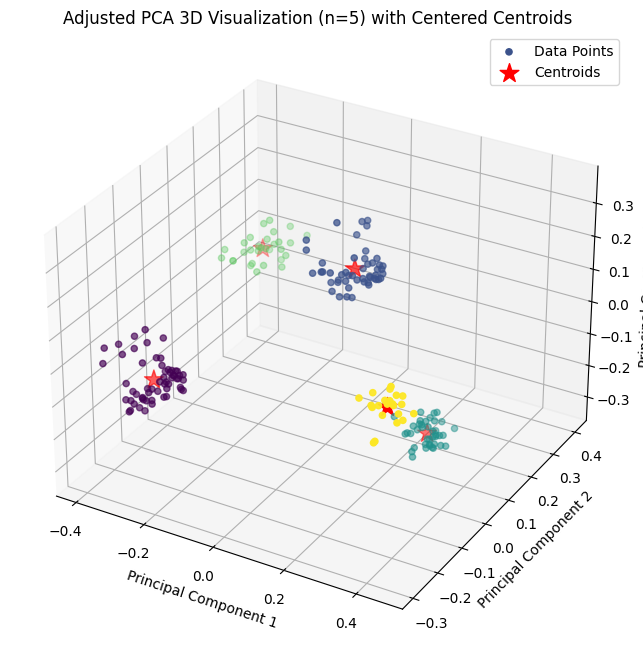

In [12]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(adjusted_data)

# Compute 3D adjusted centroids
adjusted_centroids_3d = np.array([pca_result_3d[df_clean['Cluster_Adjusted'] == i].mean(axis=0) for i in range(5)])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2], c=df_clean['Cluster_Adjusted'], cmap='viridis', label='Data Points')
ax.scatter(adjusted_centroids_3d[:, 0], adjusted_centroids_3d[:, 1], adjusted_centroids_3d[:, 2], c='red', marker='*', s=200, label='Centroids')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Adjusted PCA 3D Visualization (n=5) with Centered Centroids')
ax.legend()
plt.show()

In [13]:
data['Cluster'] = kmeans.labels_
data_unscaled = pd.DataFrame(scaler.inverse_transform(data_scaled), columns=data.columns[:-1])
data_unscaled['Cluster'] = kmeans.labels_
print(data_unscaled.groupby('Cluster').mean().round(2))


           Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                   
0        55.55               48.48                   41.78
1        32.88               86.10                   81.53
2        27.06               51.98                   41.04
3        44.00               90.13                   17.93
4        25.52               26.30                   78.57


# 8. Business Insight – Cluster to Action Mapping

In [14]:
# Business Insights using Adjusted Clusters
marketing_actions = {
    0: "High-Value VIPs – Offer VIP memberships, early access to luxury items",
    1: "Stable Mid-Income Adults – Offer loyalty programs and seasonal bundles",
    2: "Wealthy but Cautious – Push exclusive deals, personalized offers",
    3: "Impulsive Young Shoppers – Promote discounts & flash sales",
    4: "Low Engagement – Use reactivation campaigns or low-cost promos"
}

df_clean['Marketing Action'] = df_clean['Cluster_Adjusted'].map(marketing_actions)
target_customers = df_clean[df_clean['Cluster_Adjusted'].isin([0, 3])]  # Adjust based on new clustering
print("Target Customers for Campaign (Adjusted Clusters):\n", target_customers.head())
target_customers.to_csv("target_customers_adjusted.csv", index=False)
print("Target customers saved to 'target_customers_adjusted.csv'")

Target Customers for Campaign (Adjusted Clusters):
     Age  Annual Income (k$)  Spending Score (1-100)  Cluster  \
8    64                  19                       3        0   
10   67                  19                      14        0   
12   58                  20                      15        0   
18   52                  23                      29        0   
22   46                  25                       5        0   

    Cluster_Adjusted                                   Marketing Action  
8                  0  High-Value VIPs – Offer VIP memberships, early...  
10                 0  High-Value VIPs – Offer VIP memberships, early...  
12                 0  High-Value VIPs – Offer VIP memberships, early...  
18                 0  High-Value VIPs – Offer VIP memberships, early...  
22                 0  High-Value VIPs – Offer VIP memberships, early...  
Target customers saved to 'target_customers_adjusted.csv'


# 9. Model Saving 

In [15]:
import joblib
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
kmeans.fit(data_scaled)
df_clean['Cluster'] = kmeans.labels_


# Apply pull factor adjustment to training data
pull_factor = 0.7
adjusted_data = data_scaled.copy()
for i in range(len(data_scaled)):
    cluster_center = kmeans.cluster_centers_[kmeans.labels_[i]]
    adjusted_data[i] = adjusted_data[i] * (1 - pull_factor) + cluster_center * pull_factor

# Train adjusted KMeans model
kmeans_adjusted = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
kmeans_adjusted.fit(adjusted_data)
df_clean['Cluster_Adjusted'] = kmeans_adjusted.labels_

# Save adjusted model and scaler
joblib.dump(kmeans_adjusted, 'kmeans_adjusted_model.pkl')
joblib.dump(scaler, 'scaler_adjusted.pkl')

# target customers with adjusted clusters
marketing_actions = {
    0: "High-Value VIPs – Offer VIP memberships, early access to luxury items",
    1: "Stable Mid-Income Adults – Offer loyalty programs and seasonal bundles",
    2: "Wealthy but Cautious – Push exclusive deals, personalized offers",
    3: "Impulsive Young Shoppers – Promote discounts & flash sales",
    4: "Low Engagement – Use reactivation campaigns or low-cost promos"
}
df_clean['Marketing Action'] = df_clean['Cluster_Adjusted'].map(marketing_actions)
target_customers = df_clean[df_clean['Cluster_Adjusted'].isin([0, 3])]
target_customers.to_csv("target_customers_adjusted.csv", index=False)
print("Target customers saved to 'target_customers_adjusted.csv'")


Target customers saved to 'target_customers_adjusted.csv'


# 10. Model Prediction

In [16]:
def predict_customer_cluster(new_customer_data, scaler, kmeans, kmeans_adjusted, pull_factor=0.7):
    if new_customer_data.shape[1] != 3:
        raise ValueError("Expected input with 3 features: Age, Annual Income (k$), Spending Score (1-100)")
    new_scaled = scaler.transform(new_customer_data)
    original_cluster = kmeans.predict(new_scaled)[0]
    cluster_center = kmeans.cluster_centers_[original_cluster]
    adjusted_data = new_scaled * (1 - pull_factor) + cluster_center * pull_factor
    cluster = kmeans_adjusted.predict(adjusted_data)
    return cluster[0]

new_customer_0 = pd.DataFrame([[50, 45, 50]], columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
cluster_0 = predict_customer_cluster(new_customer_0, scaler, kmeans, kmeans_adjusted, pull_factor=0.7)

print(f"Predicted cluster for Customer 1 (Age=50, Income=45k, Score=50): {cluster_0}")

new_customer_3 = pd.DataFrame([[35, 90, 20]], columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
cluster_3 =predict_customer_cluster(new_customer_3, scaler, kmeans, kmeans_adjusted, pull_factor=0.7)

print(f"Predicted cluster for Customer 2 (Age=35, Income=90k, Score=20): {cluster_3}")

Predicted cluster for Customer 1 (Age=50, Income=45k, Score=50): 0
Predicted cluster for Customer 2 (Age=35, Income=90k, Score=20): 3
